In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [2]:
#import NVDA ticker data
nvda_data = yf.download("NVDA", start="2000-01-01", auto_adjust=True, multi_level_index=False)
nvda_data.head()

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,0.089415,0.090967,0.084282,0.090251,300912000
2000-01-04,0.087028,0.088102,0.082610,0.087863,300480000
2000-01-05,0.084163,0.085953,0.082969,0.084521,188352000
2000-01-06,0.078671,0.084163,0.075448,0.084163,120480000
2000-01-07,0.079985,0.080820,0.077120,0.078313,71184000


In [3]:
#flattening of columns to allows for analysis
nvda_data.columns = nvda_data.columns.get_level_values(0)

#Make date a column and not an index 
nvda_data = nvda_data.reset_index()

nvda_data.head()

,Date,Close,High,Low,Open,Volume
0,2000-01-03,0.089415,0.090967,0.084282,0.090251,300912000
1,2000-01-04,0.087028,0.088102,0.082610,0.087863,300480000
2,2000-01-05,0.084163,0.085953,0.082969,0.084521,188352000
3,2000-01-06,0.078671,0.084163,0.075448,0.084163,120480000
4,2000-01-07,0.079985,0.080820,0.077120,0.078313,71184000


In [4]:
#Load and Inspect QQQ data

QQQ_data = pd.read_csv("market_data/QQQ_split_adj.csv")

QQQ_data.head()

,date,open,high,low,close,volume,raw_close,change_percent,avg_vol_20d
0,1999-03-10,51.06250,51.15625,50.28125,51.0625,5232200,102.125,NaN,NaN
1,1999-03-11,51.43750,51.73440,50.31250,51.3125,9688600,102.625,0.49,NaN
2,1999-03-12,51.12500,51.15625,49.65625,50.0625,8743600,100.125,-2.44,NaN
3,1999-03-15,50.43750,51.56250,49.90625,51.5000,6369000,103.000,2.87,NaN
4,1999-03-16,51.71875,52.15625,51.15625,51.9375,4905800,103.875,0.85,NaN


In [5]:
#Data clean up and changing NVDA column names to match QQQ and label prices

nvda_data = nvda_data.rename(columns={
    "Date": "date",
    "Close": "close_NVDA",
    "High": "high_NVDA",
    "Low": "low_NVDA",
    "Open": "open_NVDA",
    "Volume": "volume_NVDA"
    })

#Rename QQQ price columns

QQQ_data = QQQ_data.rename(columns={
    "date": "date",
    "close": "close_QQQ",
    "high": "high_QQQ",
    "low": "low_QQQ",
    "open": "open_QQQ",
    "volume": "volume_QQQ"
    })

#Enforce dateTime object casting
nvda_data['date'] = pd.to_datetime(nvda_data['date'])
QQQ_data['date'] = pd.to_datetime(QQQ_data['date'])

#Filter QQQ data to start from 2000

QQQ_data = QQQ_data[QQQ_data['date'] >= '2000-01-01']

#Drop redundant columns

QQQ_data = QQQ_data.drop(["raw_close", "change_percent", "avg_vol_20d"], axis = 1, errors = 'ignore')

QQQ_data.head()




,date,open_QQQ,high_QQQ,low_QQQ,close_QQQ,volume_QQQ
207,2000-01-03,96.1875,96.18750,90.0000,94.7500,36358000
208,2000-01-04,92.0000,93.50000,87.9375,88.0078,33782800
209,2000-01-05,87.5000,90.03125,84.2500,86.1875,42498398
210,2000-01-06,86.8750,88.00000,80.0000,80.7500,37009398
211,2000-01-07,82.9375,88.50000,82.5000,88.5000,28129400


In [6]:
#Remove ghost header

nvda_data.columns.name = None
nvda_data.head()

,date,close_NVDA,high_NVDA,low_NVDA,open_NVDA,volume_NVDA
0,2000-01-03,0.089415,0.090967,0.084282,0.090251,300912000
1,2000-01-04,0.087028,0.088102,0.082610,0.087863,300480000
2,2000-01-05,0.084163,0.085953,0.082969,0.084521,188352000
3,2000-01-06,0.078671,0.084163,0.075448,0.084163,120480000
4,2000-01-07,0.079985,0.080820,0.077120,0.078313,71184000


In [7]:
#Table merging

data_study = pd.merge(nvda_data, QQQ_data, on='date', how='inner')

data_study.head()

,date,close_NVDA,high_NVDA,low_NVDA,open_NVDA,volume_NVDA,open_QQQ,high_QQQ,low_QQQ,close_QQQ,volume_QQQ
0,2000-01-03,0.089415,0.090967,0.084282,0.090251,300912000,96.1875,96.18750,90.0000,94.7500,36358000
1,2000-01-04,0.087028,0.088102,0.082610,0.087863,300480000,92.0000,93.50000,87.9375,88.0078,33782800
2,2000-01-05,0.084163,0.085953,0.082969,0.084521,188352000,87.5000,90.03125,84.2500,86.1875,42498398
3,2000-01-06,0.078671,0.084163,0.075448,0.084163,120480000,86.8750,88.00000,80.0000,80.7500,37009398
4,2000-01-07,0.079985,0.080820,0.077120,0.078313,71184000,82.9375,88.50000,82.5000,88.5000,28129400


In [8]:
data_study.tail()

,date,close_NVDA,high_NVDA,low_NVDA,open_NVDA,volume_NVDA,open_QQQ,high_QQQ,low_QQQ,close_QQQ,volume_QQQ
6104,2024-04-09,85.310463,87.590305,82.979659,87.397403,501700000,442.96,443.2400,437.44,442.23,39521600
6105,2024-04-10,86.994621,87.355437,83.666317,83.883210,431929000,437.00,439.2400,436.28,438.37,61502200
6106,2024-04-11,90.569794,90.692732,86.881680,87.375424,431637000,440.26,446.3300,437.96,445.37,45474600
6107,2024-04-12,88.141029,90.129021,87.485366,89.653258,426805000,441.10,442.2400,436.88,438.27,53602600
6108,2024-04-15,85.957138,90.566785,85.885176,89.052559,443077000,442.07,442.0901,430.21,431.06,62937433


In [9]:
#Reset Index

data_study=data_study.reset_index(drop=True)
data_study.head()

,date,close_NVDA,high_NVDA,low_NVDA,open_NVDA,volume_NVDA,open_QQQ,high_QQQ,low_QQQ,close_QQQ,volume_QQQ
0,2000-01-03,0.089415,0.090967,0.084282,0.090251,300912000,96.1875,96.18750,90.0000,94.7500,36358000
1,2000-01-04,0.087028,0.088102,0.082610,0.087863,300480000,92.0000,93.50000,87.9375,88.0078,33782800
2,2000-01-05,0.084163,0.085953,0.082969,0.084521,188352000,87.5000,90.03125,84.2500,86.1875,42498398
3,2000-01-06,0.078671,0.084163,0.075448,0.084163,120480000,86.8750,88.00000,80.0000,80.7500,37009398
4,2000-01-07,0.079985,0.080820,0.077120,0.078313,71184000,82.9375,88.50000,82.5000,88.5000,28129400


In [10]:
#check for missng values (NaN)

print(data_study.isnull().sum())

date           0
close_NVDA     0
high_NVDA      0
low_NVDA       0
open_NVDA      0
volume_NVDA    0
open_QQQ       0
high_QQQ       0
low_QQQ        0
close_QQQ      0
volume_QQQ     0
dtype: int64


In [11]:
#Check for duplicates

print(data_study.duplicated().sum())

0


In [12]:
#Check Data types

data_study.dtypes

date           datetime64[ns]
close_NVDA            float64
high_NVDA             float64
low_NVDA              float64
open_NVDA             float64
volume_NVDA             int64
open_QQQ              float64
high_QQQ              float64
low_QQQ               float64
close_QQQ             float64
volume_QQQ              int64
dtype: object

In [13]:
#Size Inspection
data_study.shape

(6109, 11)

In [14]:
#Calculate the percetage change between the current day close and previous close
data_study['NVDA_pct'] = data_study['close_NVDA'].pct_change()
data_study['QQQ_pct'] = data_study['close_QQQ'].pct_change()

data_study.head()

,date,close_NVDA,high_NVDA,low_NVDA,open_NVDA,volume_NVDA,open_QQQ,high_QQQ,low_QQQ,close_QQQ,volume_QQQ,NVDA_pct,QQQ_pct
0,2000-01-03,0.089415,0.090967,0.084282,0.090251,300912000,96.1875,96.18750,90.0000,94.7500,36358000,NaN,NaN
1,2000-01-04,0.087028,0.088102,0.082610,0.087863,300480000,92.0000,93.50000,87.9375,88.0078,33782800,-0.026701,-0.071158
2,2000-01-05,0.084163,0.085953,0.082969,0.084521,188352000,87.5000,90.03125,84.2500,86.1875,42498398,-0.032922,-0.020683
3,2000-01-06,0.078671,0.084163,0.075448,0.084163,120480000,86.8750,88.00000,80.0000,80.7500,37009398,-0.065253,-0.063089
4,2000-01-07,0.079985,0.080820,0.077120,0.078313,71184000,82.9375,88.50000,82.5000,88.5000,28129400,0.016700,0.095975


In [15]:
#Drop initial empty row
data_study = data_study.dropna()

data_study.head()

,date,close_NVDA,high_NVDA,low_NVDA,open_NVDA,volume_NVDA,open_QQQ,high_QQQ,low_QQQ,close_QQQ,volume_QQQ,NVDA_pct,QQQ_pct
1,2000-01-04,0.087028,0.088102,0.082610,0.087863,300480000,92.0000,93.50000,87.9375,88.0078,33782800,-0.026701,-0.071158
2,2000-01-05,0.084163,0.085953,0.082969,0.084521,188352000,87.5000,90.03125,84.2500,86.1875,42498398,-0.032922,-0.020683
3,2000-01-06,0.078671,0.084163,0.075448,0.084163,120480000,86.8750,88.00000,80.0000,80.7500,37009398,-0.065253,-0.063089
4,2000-01-07,0.079985,0.080820,0.077120,0.078313,71184000,82.9375,88.50000,82.5000,88.5000,28129400,0.016700,0.095975
5,2000-01-10,0.082610,0.085953,0.078791,0.080223,239856000,91.0000,93.93750,89.9375,92.2500,29672200,0.032829,0.042373


In [16]:
# Grouping by the actual calendar quarter (Q-DEC means year ends in Dec)
quarterly_corr = data_study.groupby(data_study['date'].dt.to_period('Q')).apply(
    lambda x: x['NVDA_pct'].corr(x['QQQ_pct'])
)

quarterly_corr.head()

date
2000Q1    0.156374
2000Q2    0.537377
2000Q3    0.444046
2000Q4    0.673969
2001Q1    0.705404
Freq: Q-DEC, dtype: float64

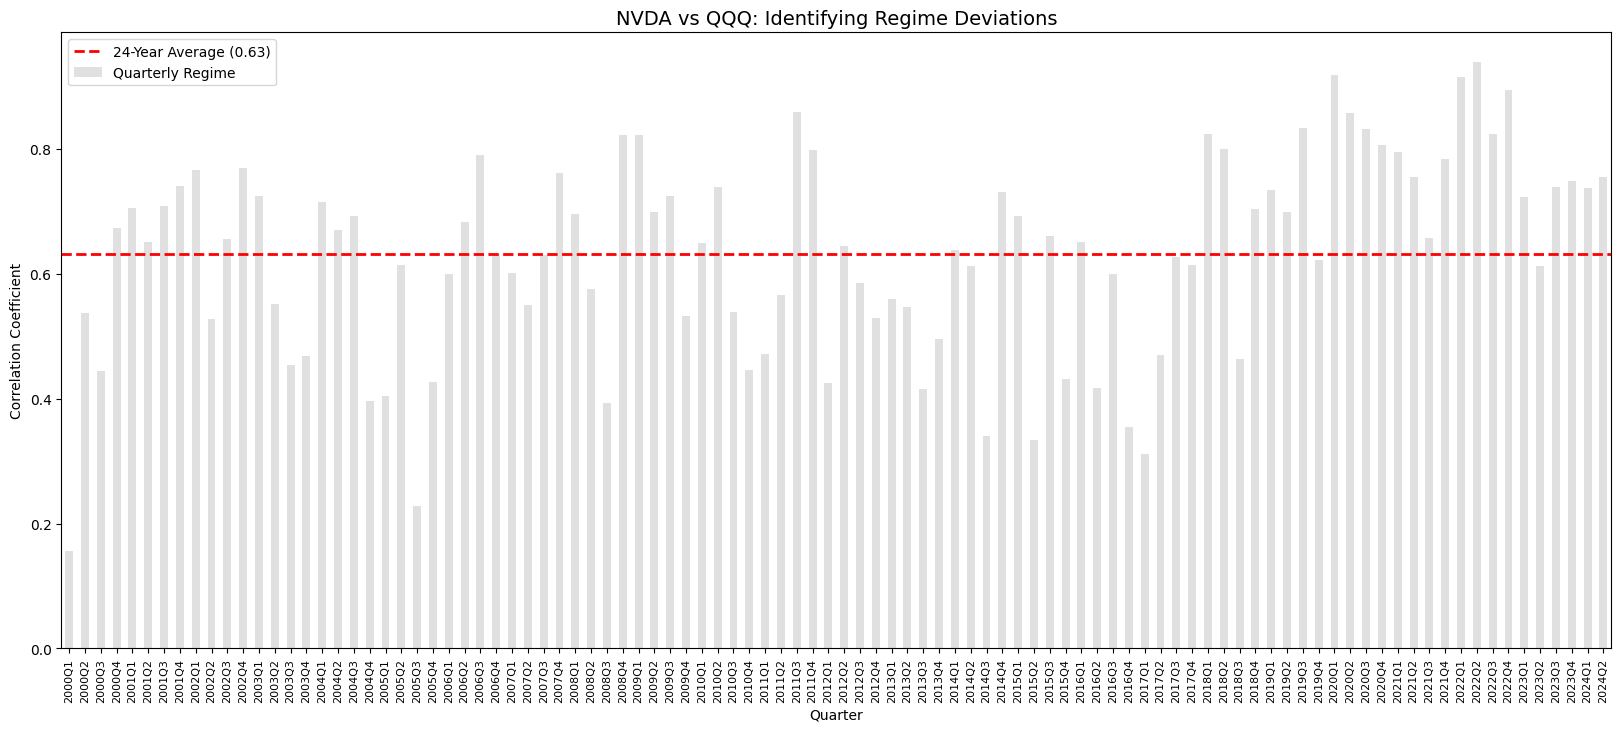

In [23]:
#Get the overall correlation value
overall_corr_val = data_study['NVDA_pct'].corr(data_study['QQQ_pct'])

# 2. Create the plot
plt.figure(figsize=(20, 8))

# Plot the Quarterly Correlation as a Bar Chart
quarterly_corr.plot(kind='bar', color='lightgray', alpha=0.7, label='Quarterly Regime')

# Plot the Overall Correlation as a solid Horizontal Line
plt.axhline(y=overall_corr_val, color='red', linestyle='--', linewidth=2, label=f'24-Year Average ({overall_corr_val:.2f})')

# Customizing the look
plt.title('NVDA vs QQQ: Identifying Regime Deviations', fontsize=14)
plt.ylabel('Correlation Coefficient')
plt.xlabel('Quarter')
plt.legend()
plt.xticks(rotation=(90), fontsize = 8)
plt.show()